In [1]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [2]:
import sys
import os
 
# getting the current directory
current = os.getcwd()
 
# Getting the parent directory
parent = os.path.dirname(current)
 
# adding the parent directory to the sys.path.
sys.path.append(parent)
 
from FMTSClust import *
import numpy as np
import pandas as pd

In [8]:
# STEP 1 - DATA EXTRACTION
# use glob to get all the csv files 
# in the folder
path = "./Data"

df = getFAWNdata(path)
df.shape

(314602, 7)

In [9]:
df.to_csv('FAWN_Step1_Output.csv', index=False)

In [10]:
df = pd.read_csv('FAWN_Step1_Output.csv')

In [11]:
# STEP 2 - PREPROCESSING

# FILTERING

# Years: 2003 - 2023

# Season:
#   StAS = November to February
#   BAS = December to May
# Total Season: StAS + BAS {nov, dec, jan, feb, mar, apr, may} - 212 days

# one day after, one day before
df_filtered = filterByDate(df, "2003", "2023", "10-31", "06-01")


In [12]:
df_filtered.shape

(163454, 7)

In [8]:
df_stations, stations_ids = check_data_availability_stations(df_filtered, 20)

In [9]:
stations_ids

array([110, 130, 140, 150, 160, 170, 180, 230, 240, 250, 260, 270, 280,
       290, 302, 303, 304, 320, 330, 340, 350, 360, 380, 410, 420, 440,
       450, 460, 470])

In [10]:
df_stations.shape

(122593, 7)

In [11]:
#quality checking

QC_missing_null_values(df_stations,"fawn")

Maximum number of measurements: 122960
Real number of measurements: 122593
Missing measurements: 367
Missing Values (%): 0.0029847104749512036

Null values: 1342
%: 0.010914118412491867


In [12]:
#quality checking

QC_outliers(df_stations)

Upper_limit_T: 33.804500000000004
Lower_limit_T: 3.5525
Temperature Outliers: 1190
Upper_limit_RH: 105.67549999999997
Lower_limit_RH: 48.81550000000002
Relative Humidity Outliers: 1288
Upper_limit_RF: 0.0225
Lower_limit_RF: -0.013499999999999998
Rainfall Outliers: 23150
Upper_limit_SR: 34.268899
Lower_limit_SR: -3.9385649999999988
Solar Radiation Outliers: 32


In [13]:
df_stations.to_csv('FAWN_Step2_Output.csv', index=False)

In [14]:
# STEP 3 - FEATURE ENGINEERING

# aggregation
df = pd.read_csv('FAWN_Step2_Output.csv')

In [15]:
df.shape

(122593, 7)

In [16]:
columns=['Temperature','RelatHumidity','Rainfall','SolarRad']
df_days = daily_aggregation(df,columns)

Minimum and maximum values for each variable:
> Temperature:
Min: 9.06ºC     Max: 27.15ºC

> Relative Humidity:
Min: 63.47%      Max: 88.52%

> Rainfall:
Min: 0.0"       Max: 0.01"

> Solar Radiation:
Min: 6.04 MJm2  Max: 26.68 MJm2



In [17]:
columns=['Temperature','RelatHumidity','Rainfall','SolarRad']
df_std = standardization(df_days, columns)

In [18]:
df_std.head()

StationID  doy  Temperature  RelatHumidity  Rainfall  SolarRad
0        110    1    -1.203898       1.501730  3.065413 -1.709293
1        110    2    -1.489656       1.136262  1.039038 -1.708913
2        110    3    -1.898296       0.657389  0.719084 -1.401799
3        110    4    -2.031141       0.314839  0.505781 -1.028853
4        110    5    -1.928181       0.666767  0.339879 -1.038716

In [19]:
df_days.shape

(6148, 6)

In [20]:
df_std.shape

(6148, 6)

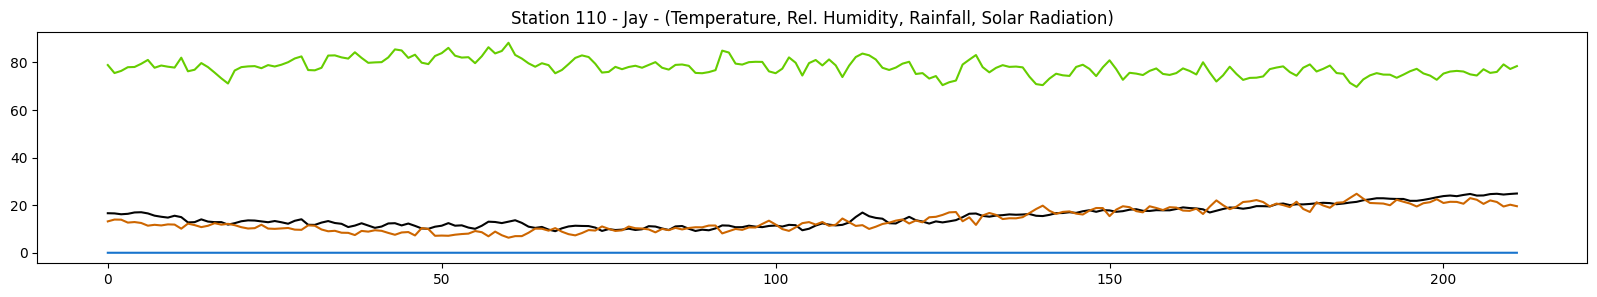

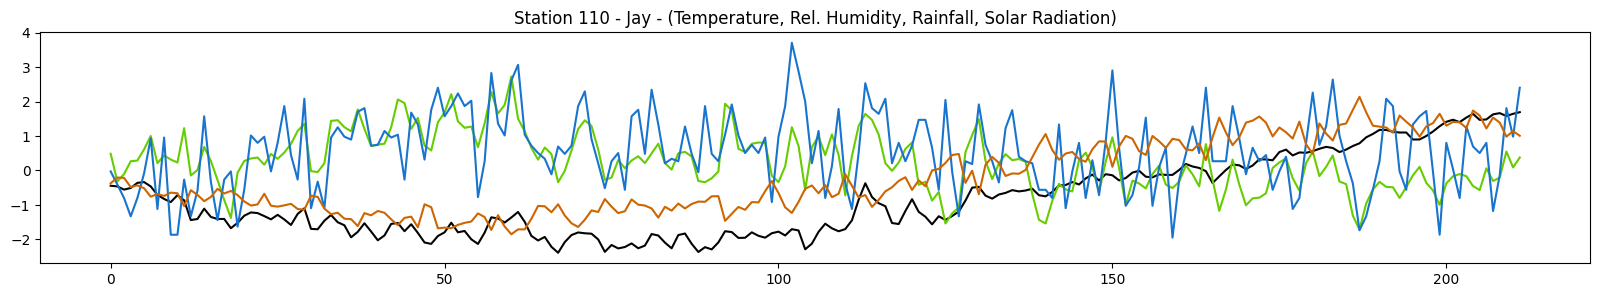

In [22]:
# Comparing Normal and Standardized Data
stations_list = df_days['StationID'].unique()
allColumns=['Temperature', 'RelatHumidity', 'Rainfall', 'SolarRad']


# DOY = 151 = May 31
doy_lower = 151

# DOY = 305 = November 1
doy_upper = 305

df_array = transform_dfTS_to_3Darray_DOYsorted(df_days,allColumns,doy_lower, doy_upper)
plot_first_TS(df_array,stations_list)

df_array_std = transform_dfTS_to_3Darray_DOYsorted(df_std,allColumns,doy_lower, doy_upper)
plot_first_TS(df_array_std,stations_list)

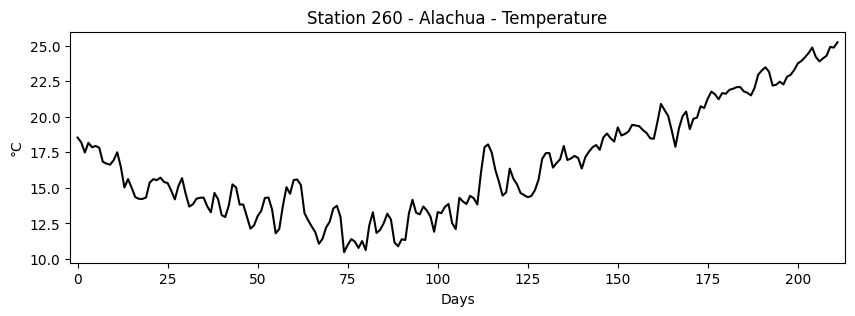

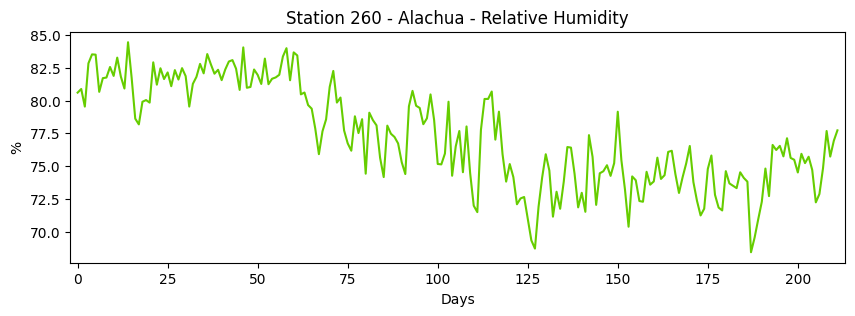

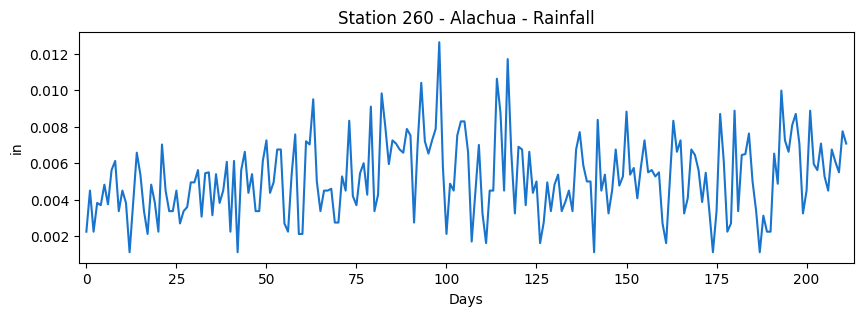

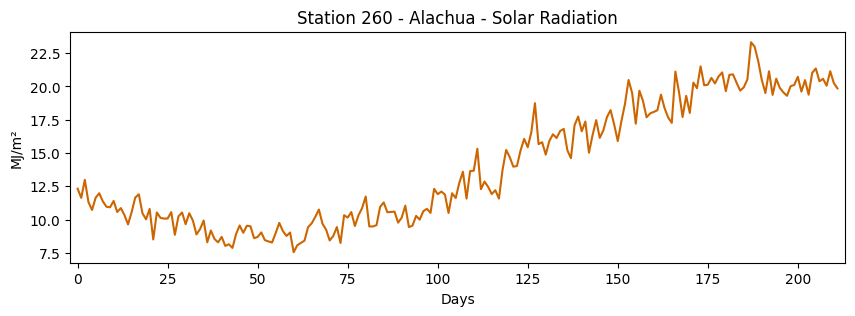

In [23]:
# Visualizing independent variables
plot_TS_by_index_separated_variables(df_array, stations_list, 10)

In [24]:
df_std.to_csv('FAWN_Step3_Output.csv', index=False)

In [3]:
# STEP 4 - CLUSTERING

df_std = pd.read_csv('FAWN_Step3_Output.csv')
df_std.dtypes

StationID          int64
doy                int64
Temperature      float64
RelatHumidity    float64
Rainfall         float64
SolarRad         float64
dtype: object

In [4]:
df_std.shape

(6148, 6)

In [5]:
allColumns=['Temperature', 'RelatHumidity', 'Rainfall', 'SolarRad']

# DOY = 151 = May 31
doy_lower = 151

# DOY = 305 = November 1
doy_upper = 305

df_array_std = transform_dfTS_to_3Darray_DOYsorted(df_std,allColumns,doy_lower,doy_upper)
df_array_std.shape

(29, 212, 4)

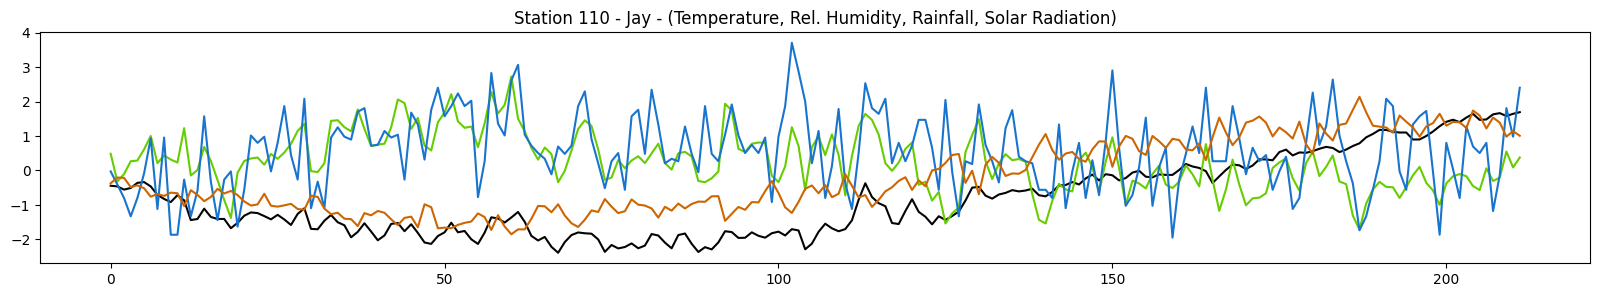

In [8]:
stations_list = df_std['StationID'].unique()
plot_first_TS(df_array_std,stations_list)

In [11]:
unique_station_ids = df_std['StationID'].unique()

stations = pd.read_csv('StationsList.csv')
names = stations[['StationName','StationID']]
names_sort = names.sort_values(by=['StationID'])
names_sort.head()

StationName  StationID
19               Jay        110
11  Defuniak Springs        120
27              Mayo        121
26          Marianna        130
38            Quincy        140

In [12]:
flattened_df_std = flatten_multivariate_time_series(df_array_std)
flattened_df_std.head()

station0_feature0  station0_feature1  station0_feature2  station0_feature3  \
0          -0.442864           0.485180          -0.027476          -0.371106   
1          -0.461619          -0.320417          -0.406680          -0.204003   
2          -0.555331          -0.105242          -0.797735          -0.214294   
3          -0.507361           0.268011          -1.330992          -0.480219   
4          -0.359239           0.288215          -0.797735          -0.431211   

   station1_feature0  station1_feature1  station1_feature2  station1_feature3  \
0          -0.282518          -0.005699          -0.264478          -0.364781   
1          -0.365860          -0.343555          -0.323729          -0.390608   
2          -0.414036          -0.779600          -1.330992          -0.109035   
3          -0.340419          -0.271661          -0.667383          -0.497505   
4          -0.316808          -0.394575          -1.093989          -0.505605   

   station2_feature0  station2_feature1  ...  station26_feature2  \
0          -0.253084           0.266801  ...            0.659833   
1          -0.402172           0.281257  ...           -0.667383   
2          -0.387900          -0.232324  ...           -0.560732   
3          -0.358595           0.700924  ...           -0.264478   
4          -0.332394           0.317485  ...           -0.667383   

   station26_feature3  station27_feature0  station27_feature1  \
0           -0.056917            1.142939            1.242463   
1            0.055585            1.078842            1.037750   
2            0.049812            0.951381            0.837467   
3           -0.311975            0.970072            1.138915   
4           -0.335089            0.884514            1.309232   

   station27_feature2  station27_feature3  station28_feature0  \
0            0.873136           -0.209050            1.167079   
1           -0.371130           -0.298752            1.025861   
2           -0.691084           -0.299703            0.924498   
3           -0.264478           -0.586698            1.002700   
4            0.102876           -0.500074            0.886421   

   station28_feature1  station28_feature2  station28_feature3  
0            0.752722           -1.117689           -0.355911  
1            0.718517            0.849435           -0.441655  
2            0.146545           -1.330992           -0.247952  
3            0.540188           -1.117689           -0.599843  
4            0.681330            0.162127           -0.569137  

[5 rows x 116 columns]

In [13]:
flattened_df_std.shape

(212, 116)

Clusters = 2  Silhouette Score: 0.247
Clusters = 3  Silhouette Score: 0.194
Clusters = 4  Silhouette Score: 0.169
Clusters = 5  Silhouette Score: 0.174
Clusters = 6  Silhouette Score: 0.173
Clusters = 7  Silhouette Score: 0.120
Clusters = 8  Silhouette Score: 0.122
Clusters = 9  Silhouette Score: 0.146
Clusters = 10  Silhouette Score: 0.130


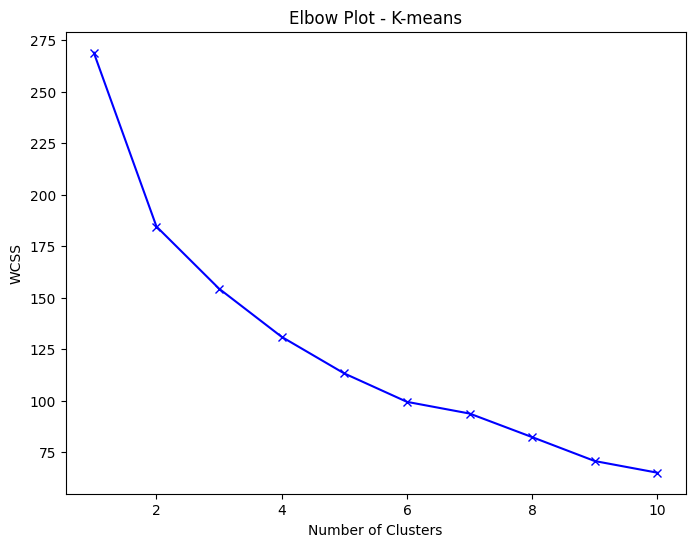

In [14]:
# K-MEANS

# Silhouette Score and Elbow Plot
sil_and_elbow_scores_TSKMeans(df_array_std,11,"euclidean",10,150)

Cluster 0
RMSE for station 0: 0.3284571933637548
RMSE for station 1: 0.3466887121757076
RMSE for station 2: 0.3582278119449044
RMSE for station 3: 0.3102558835674096
RMSE for station 4: 0.36055814141598924
RMSE for station 5: 0.24936131157803423
RMSE for station 6: 0.41456387049284593
RMSE for station 7: 0.3807714154261542
RMSE for station 8: 0.38667013677523326
RMSE for station 9: 0.41655166921791614
RMSE for station 10: 0.47293818480514843
RMSE for station 11: 0.4805124252984859
RMSE for station 12: 0.484745378869748
RMSE for station 13: 0.46620019857047246
RMSE for station 14: 0.37092921215802427
RMSE for station 15: 0.3148494477650037
RMSE for Cluster 0: 0.38389256208905204
Cluster 1
RMSE for station 0: 0.4830394145191497
RMSE for station 1: 0.35259612470497137
RMSE for station 2: 0.28448058375945806
RMSE for station 3: 0.4093002852070805
RMSE for station 4: 0.355309146243103
RMSE for station 5: 0.3161886746296748
RMSE for station 6: 0.33985876774390233
RMSE for station 7: 0.321942

0.3650677865829775

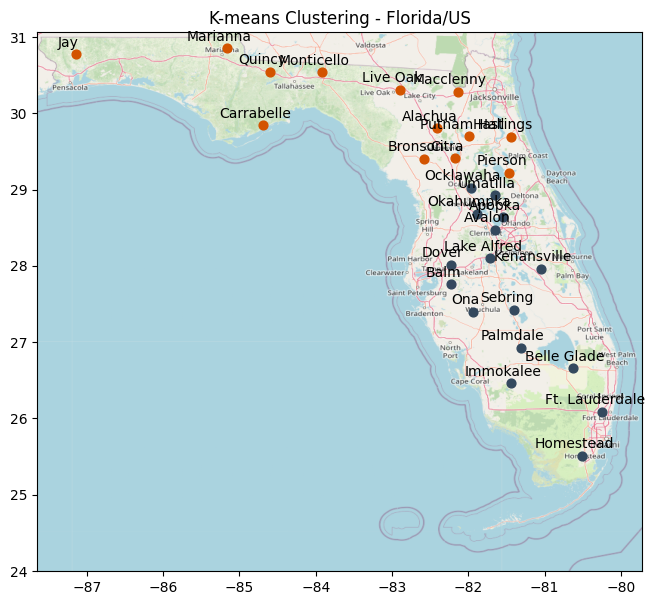

In [15]:
# K = 2
n_clusters=2
y_pred_Kmeans_std = cluster_labels_TSKmeans(df_array_std,n_clusters,"euclidean",10,50)
stations_map = stations[stations.StationID.isin(unique_station_ids) == True]
plot_map_clustering_names(stations_map,y_pred_Kmeans_std, "K-means Clustering - Florida/US","fawn")

# cluster evaluation
calculate_cluster_rmse(flattened_df_std, y_pred_Kmeans_std)

Cluster 0
RMSE for station 0: 0.37457516176495803
RMSE for station 1: 0.43175613704243926
RMSE for station 2: 0.3272672268655705
RMSE for station 3: 0.3540670863154571
RMSE for station 4: 0.3196112927633085
RMSE for station 5: 0.3481534570075948
RMSE for station 6: 0.29781293918150437
RMSE for station 7: 0.33028048845954106
RMSE for station 8: 0.28004978239608924
RMSE for station 9: 0.38026687460253683
RMSE for station 10: 0.3753300523678834
RMSE for station 11: 0.42642288897990643
RMSE for station 12: 0.45529542731183653
RMSE for station 13: 0.3706137954928933
RMSE for Cluster 0: 0.36225018646796564
Cluster 1
RMSE for station 0: 0.3992488891216407
RMSE for station 1: 0.4801314317010834
RMSE for station 2: 0.4359900550266497
RMSE for station 3: 0.38129507870858165
RMSE for station 4: 0.2784890519201188
RMSE for Cluster 1: 0.39503090129561486
Cluster 2
RMSE for station 0: 0.4748269210505274
RMSE for station 1: 0.32808799682169903
RMSE for station 2: 0.26676298285421135
RMSE for station 

0.36628944130833396

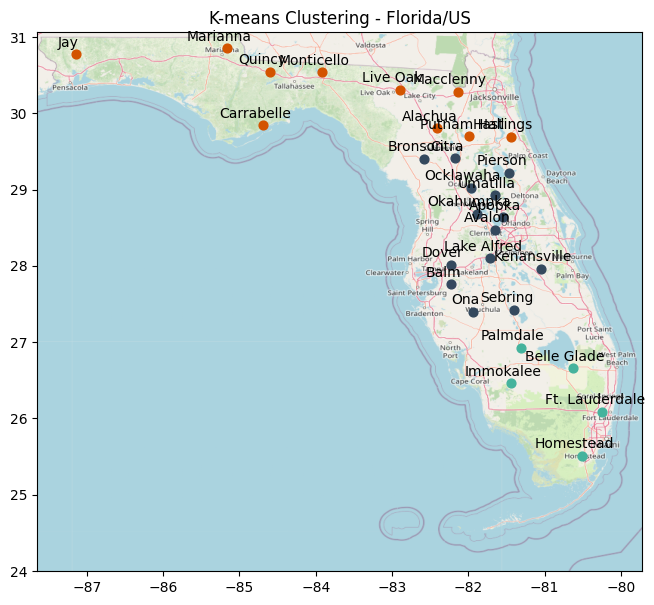

In [34]:
# K = 3
n_clusters=3
y_pred_Kmeans_std = cluster_labels_TSKmeans(df_array_std,n_clusters,"euclidean",10,50)
stations_map = stations[stations.StationID.isin(unique_station_ids) == True]
plot_map_clustering_names(stations_map,y_pred_Kmeans_std, "K-means Clustering - Florida/US","fawn")

# cluster evaluation
calculate_cluster_rmse(flattened_df_std, y_pred_Kmeans_std)

Cluster 0
RMSE for station 0: 0.2812257097949804
RMSE for station 1: 0.3551786296411574
RMSE for station 2: 0.2776150672712891
RMSE for station 3: 0.3116035121993186
RMSE for station 4: 0.24246401116468697
RMSE for station 5: 0.3708050677038837
RMSE for station 6: 0.3609704982367994
RMSE for station 7: 0.49368516465495177
RMSE for station 8: 0.38489216821901545
RMSE for Cluster 0: 0.3420488698762314
Cluster 1
RMSE for station 0: 0.4871204467193693
RMSE for station 1: 0.3404202554396245
RMSE for station 2: 0.25592715296026897
RMSE for station 3: 0.4445771774793811
RMSE for station 4: 0.35253418119509894
RMSE for Cluster 1: 0.37611584275874854
Cluster 2
RMSE for station 0: 0.3445201738007412
RMSE for station 1: 0.35443635689325176
RMSE for station 2: 0.31139863187485034
RMSE for station 3: 0.2350007435784292
RMSE for station 4: 0.32438760253128507
RMSE for station 5: 0.2862463191491784
RMSE for station 6: 0.307335560731607
RMSE for station 7: 0.34932895809994674
RMSE for station 8: 0.334

0.35945752433621975

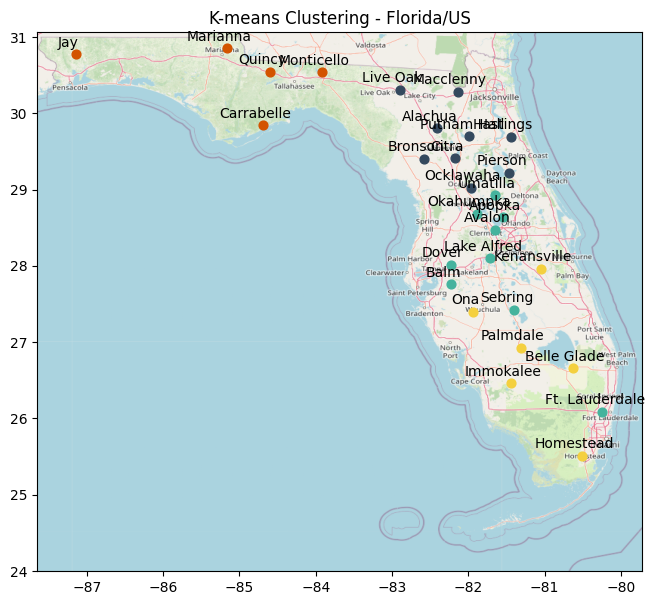

In [35]:
# K = 4
n_clusters=4
y_pred_Kmeans_std = cluster_labels_TSKmeans(df_array_std,n_clusters,"euclidean",10,50)
stations_map = stations[stations.StationID.isin(unique_station_ids) == True]
plot_map_clustering_names(stations_map,y_pred_Kmeans_std, "K-means Clustering - Florida/US","fawn")

# cluster evaluation
calculate_cluster_rmse(flattened_df_std, y_pred_Kmeans_std)

Cluster 0
RMSE for station 0: 0.539148202249284
RMSE for station 1: 0.3624328407062014
RMSE for station 2: 0.34633470576505465
RMSE for Cluster 0: 0.41597191624018004
Cluster 1
RMSE for station 0: 0.45418681448390436
RMSE for station 1: 0.3303458786704735
RMSE for station 2: 0.27542655820001977
RMSE for station 3: 0.3514960585792287
RMSE for station 4: 0.3285241532007428
RMSE for station 5: 0.35216611969285083
RMSE for station 6: 0.30887938887474087
RMSE for station 7: 0.2578971950176722
RMSE for station 8: 0.2920969883602033
RMSE for station 9: 0.28546042361748686
RMSE for Cluster 1: 0.32364795786973233
Cluster 2
RMSE for station 0: 0.3074101909223681
RMSE for station 1: 0.2890266122480355
RMSE for station 2: 0.31133109621591526
RMSE for station 3: 0.27638636523712384
RMSE for station 4: 0.3093598770923139
RMSE for station 5: 0.26597560080873633
RMSE for station 6: 0.3719172503388993
RMSE for station 7: 0.3840014071586443
RMSE for station 8: 0.40368339486695815
RMSE for station 9: 0.3

0.2924375207165942

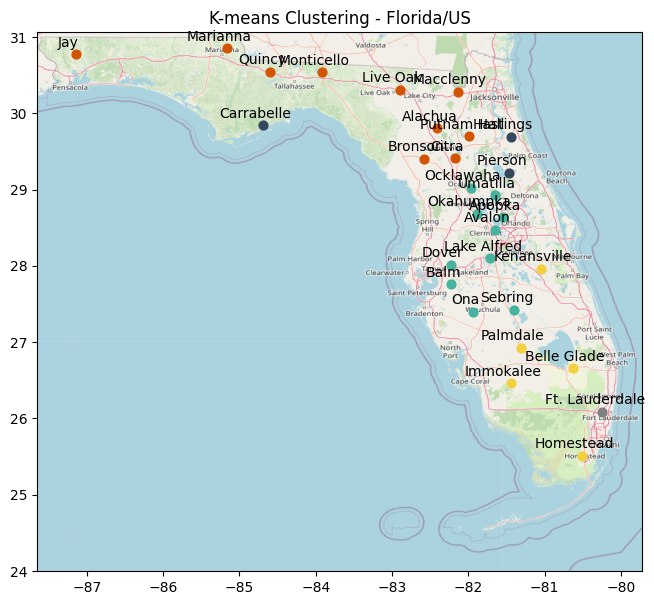

In [36]:
# K = 5
n_clusters=5
y_pred_Kmeans_std = cluster_labels_TSKmeans(df_array_std,n_clusters,"euclidean",10,50)
stations_map = stations[stations.StationID.isin(unique_station_ids) == True]
plot_map_clustering_names(stations_map,y_pred_Kmeans_std, "K-means Clustering - Florida/US","fawn")

# cluster evaluation
calculate_cluster_rmse(flattened_df_std, y_pred_Kmeans_std)

Cluster 0
RMSE for station 0: 0.41255701856601334
RMSE for station 1: 0.3985127048874739
RMSE for station 2: 0.39059347226906055
RMSE for station 3: 0.3116483273441762
RMSE for station 4: 0.3291391327178826
RMSE for Cluster 0: 0.3684901311569213
Cluster 1
RMSE for station 0: 0.4871204467193693
RMSE for station 1: 0.3404202554396245
RMSE for station 2: 0.25592715296026897
RMSE for station 3: 0.4445771774793811
RMSE for station 4: 0.35253418119509894
RMSE for Cluster 1: 0.37611584275874854
Cluster 2
RMSE for station 0: 0.32308523107825954
RMSE for station 1: 0.28790056879332643
RMSE for station 2: 0.30945868149092204
RMSE for station 3: 0.2528314663344296
RMSE for station 4: 0.2930851819502336
RMSE for station 5: 0.25010350197805287
RMSE for station 6: 0.37066673530981303
RMSE for station 7: 0.37395617900060246
RMSE for Cluster 2: 0.307635943241955
Cluster 3
RMSE for Cluster 3: 0.0
Cluster 4
RMSE for station 0: 0.3364262075513526
RMSE for station 1: 0.34941585439866146
RMSE for station 2

0.30887096652748197

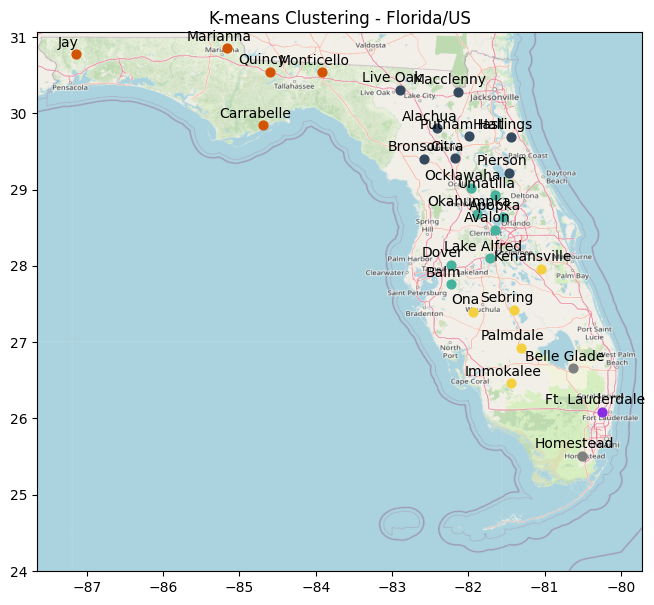

In [37]:
# K = 6
n_clusters=6
y_pred_Kmeans_std = cluster_labels_TSKmeans(df_array_std,n_clusters,"euclidean",10,50)
stations_map = stations[stations.StationID.isin(unique_station_ids) == True]
plot_map_clustering_names(stations_map,y_pred_Kmeans_std, "K-means Clustering - Florida/US","fawn")

# cluster evaluation
calculate_cluster_rmse(flattened_df_std, y_pred_Kmeans_std)

Cluster 0
RMSE for Cluster 0: 0.0
Cluster 1
RMSE for station 0: 0.37158832215980186
RMSE for station 1: 0.3247898185181097
RMSE for station 2: 0.3491224010649844
RMSE for station 3: 0.3155844750739273
RMSE for station 4: 0.24831902222102784
RMSE for station 5: 0.3015209118056239
RMSE for station 6: 0.28811862050224035
RMSE for station 7: 0.3379678817025348
RMSE for Cluster 1: 0.31712643163103127
Cluster 2
RMSE for station 0: 0.4042290278932651
RMSE for station 1: 0.38177373379836027
RMSE for station 2: 0.3365037377403337
RMSE for Cluster 2: 0.37416883314398636
Cluster 3
RMSE for station 0: 0.4754845250940361
RMSE for station 1: 0.3263558886344839
RMSE for station 2: 0.3358868243919034
RMSE for Cluster 3: 0.37924241270680775
Cluster 4
RMSE for station 0: 0.54851512348614
RMSE for station 1: 0.4572495739547722
RMSE for Cluster 4: 0.5028823487204561
Cluster 5
RMSE for station 0: 0.4209256177472389
RMSE for station 1: 0.46071957193187446
RMSE for station 2: 0.48178695350780076
RMSE for Clu

0.3356156444759261

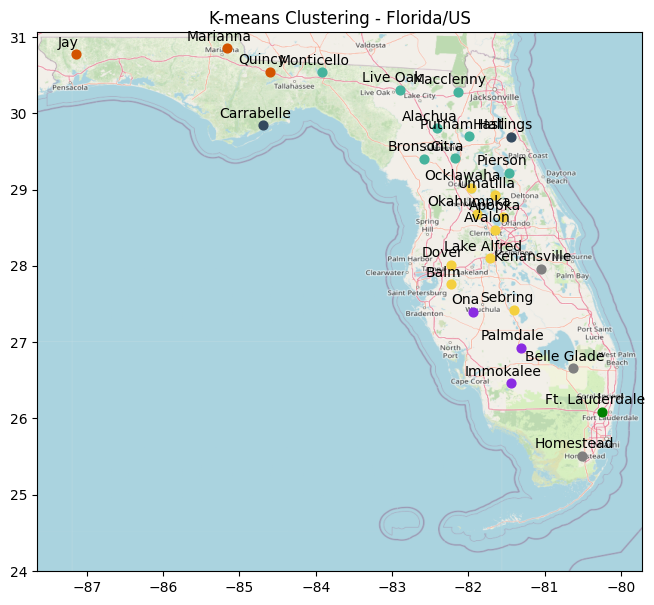

In [38]:
# K = 7
n_clusters=7
y_pred_Kmeans_std = cluster_labels_TSKmeans(df_array_std,n_clusters,"euclidean",10,50)
stations_map = stations[stations.StationID.isin(unique_station_ids) == True]
plot_map_clustering_names(stations_map,y_pred_Kmeans_std, "K-means Clustering - Florida/US","fawn")

# cluster evaluation
calculate_cluster_rmse(flattened_df_std, y_pred_Kmeans_std)

Clusters = 2  Silhouette Score: 0.247
Clusters = 3  Silhouette Score: 0.153
Clusters = 4  Silhouette Score: 0.072
Clusters = 5  Silhouette Score: 0.039
Clusters = 6  Silhouette Score: 0.056
Clusters = 7  Silhouette Score: 0.049
Clusters = 8  Silhouette Score: 0.027
Clusters = 9  Silhouette Score: 0.026
Clusters = 10  Silhouette Score: -0.043


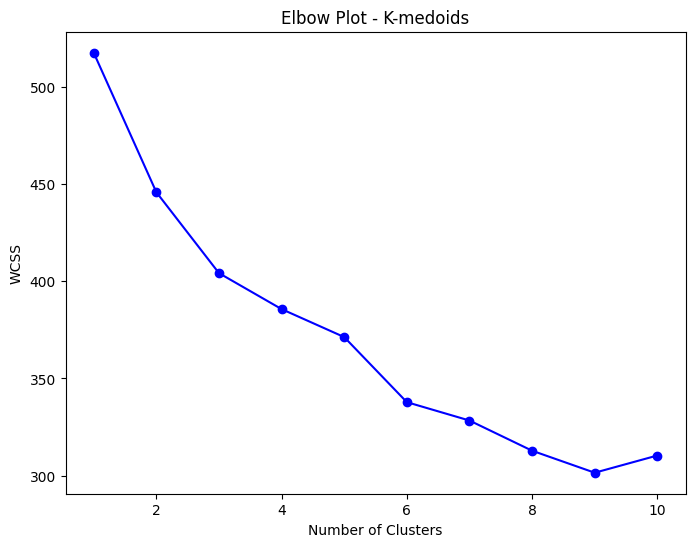

In [39]:
# K-MEDOIDS

# Silhouette Score and Elbow Plot
sil_and_elbow_scores_TSKMedoids(df_array_std, 11, 300)

Cluster 0
RMSE for station 0: 0.3284571933637548
RMSE for station 1: 0.3466887121757076
RMSE for station 2: 0.3582278119449044
RMSE for station 3: 0.3102558835674096
RMSE for station 4: 0.36055814141598924
RMSE for station 5: 0.24936131157803423
RMSE for station 6: 0.41456387049284593
RMSE for station 7: 0.3807714154261542
RMSE for station 8: 0.38667013677523326
RMSE for station 9: 0.41655166921791614
RMSE for station 10: 0.47293818480514843
RMSE for station 11: 0.4805124252984859
RMSE for station 12: 0.484745378869748
RMSE for station 13: 0.46620019857047246
RMSE for station 14: 0.37092921215802427
RMSE for station 15: 0.3148494477650037
RMSE for Cluster 0: 0.38389256208905204
Cluster 1
RMSE for station 0: 0.4830394145191497
RMSE for station 1: 0.35259612470497137
RMSE for station 2: 0.28448058375945806
RMSE for station 3: 0.4093002852070805
RMSE for station 4: 0.355309146243103
RMSE for station 5: 0.3161886746296748
RMSE for station 6: 0.33985876774390233
RMSE for station 7: 0.321942

0.3650677865829775

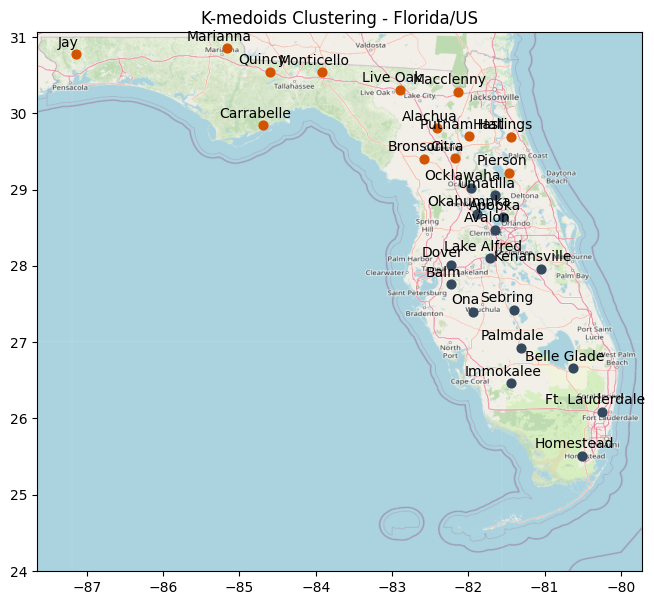

In [40]:
# K = 2
n_clusters=2
y_pred_Kmedoids_std, cluster_medoids_std = cluster_labels_TSKMedoids(df_array_std, n_clusters, 300)
stations_map = stations[stations.StationID.isin(unique_station_ids) == True]
plot_map_clustering_names(stations_map,y_pred_Kmedoids_std, "K-medoids Clustering - Florida/US","fawn")

# cluster evaluation
calculate_cluster_rmse(flattened_df_std, y_pred_Kmedoids_std)

Cluster 0
RMSE for station 0: 0.32308523107825954
RMSE for station 1: 0.28790056879332643
RMSE for station 2: 0.30945868149092204
RMSE for station 3: 0.2528314663344296
RMSE for station 4: 0.2930851819502336
RMSE for station 5: 0.25010350197805287
RMSE for station 6: 0.37066673530981303
RMSE for station 7: 0.37395617900060246
RMSE for Cluster 0: 0.307635943241955
Cluster 1
RMSE for station 0: 0.4830394145191497
RMSE for station 1: 0.35259612470497137
RMSE for station 2: 0.28448058375945806
RMSE for station 3: 0.4093002852070805
RMSE for station 4: 0.355309146243103
RMSE for station 5: 0.3161886746296748
RMSE for station 6: 0.33985876774390233
RMSE for station 7: 0.32194211457287
RMSE for station 8: 0.2740314658247366
RMSE for station 9: 0.3248629111860842
RMSE for station 10: 0.31032425299109934
RMSE for station 11: 0.33586230501322345
RMSE for station 12: 0.3933630976043854
RMSE for Cluster 1: 0.346243011076903
Cluster 2
RMSE for station 0: 0.408822979654766
RMSE for station 1: 0.3862

0.3497738667081067

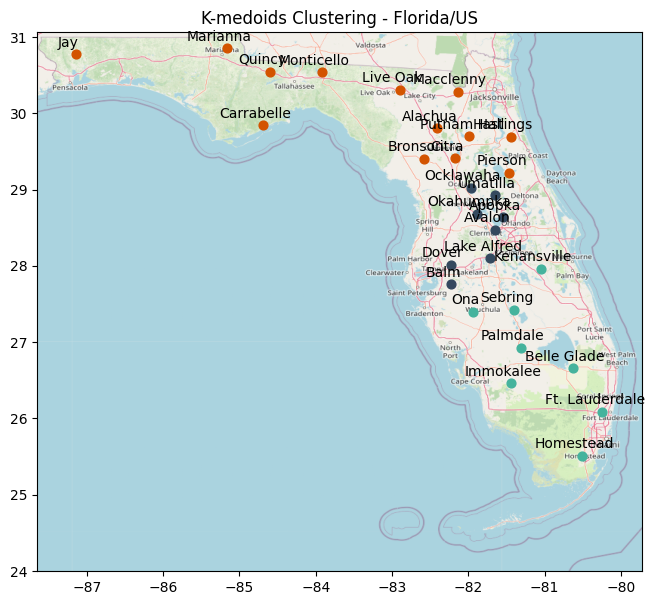

In [41]:
# K = 3
n_clusters=3
y_pred_Kmedoids_std, cluster_medoids_std = cluster_labels_TSKMedoids(df_array_std, n_clusters, 300)
stations_map = stations[stations.StationID.isin(unique_station_ids) == True]
plot_map_clustering_names(stations_map,y_pred_Kmedoids_std, "K-medoids Clustering - Florida/US","fawn")

# cluster evaluation
calculate_cluster_rmse(flattened_df_std, y_pred_Kmedoids_std)

Cluster 0
RMSE for station 0: 0.40485003525838364
RMSE for station 1: 0.2706070572041545
RMSE for station 2: 0.2750544409463364
RMSE for station 3: 0.3328241095844674
RMSE for station 4: 0.3032127069775073
RMSE for Cluster 0: 0.3173096699941698
Cluster 1
RMSE for station 0: 0.454217647151863
RMSE for station 1: 0.410792276359845
RMSE for station 2: 0.388866259341347
RMSE for station 3: 0.47636390482023744
RMSE for station 4: 0.4409377126494556
RMSE for station 5: 0.39216248159850464
RMSE for station 6: 0.3338115700295523
RMSE for Cluster 1: 0.4138788359929721
Cluster 2
RMSE for station 0: 0.2950300118579923
RMSE for station 1: 0.24518902186468733
RMSE for station 2: 0.34329754685594494
RMSE for station 3: 0.3559352356223132
RMSE for station 4: 0.3872553948924324
RMSE for Cluster 2: 0.32534144221867406
Cluster 3
RMSE for station 0: 0.4862740577954308
RMSE for station 1: 0.3495157420174393
RMSE for station 2: 0.2729544712087847
RMSE for station 3: 0.41017833361892325
RMSE for station 4: 

0.35205513942705996

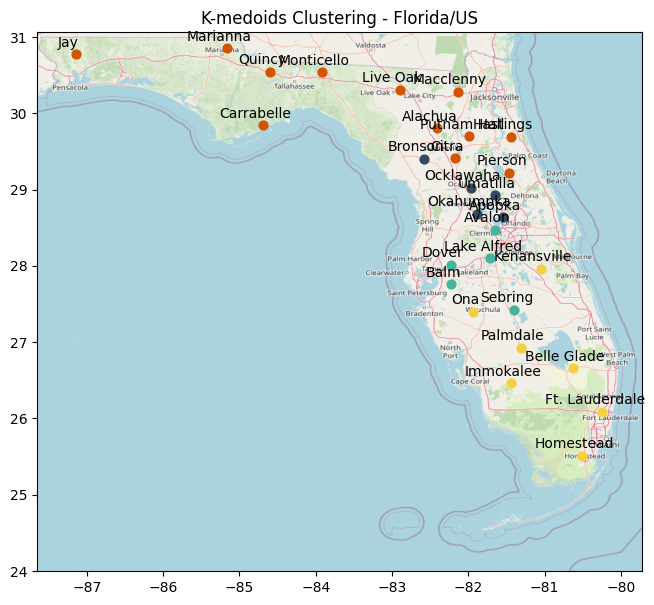

In [42]:
# K = 4
n_clusters=4
y_pred_Kmedoids_std, cluster_medoids_std = cluster_labels_TSKMedoids(df_array_std, n_clusters, 300)
stations_map = stations[stations.StationID.isin(unique_station_ids) == True]
plot_map_clustering_names(stations_map,y_pred_Kmedoids_std, "K-medoids Clustering - Florida/US","fawn")

# cluster evaluation
calculate_cluster_rmse(flattened_df_std, y_pred_Kmedoids_std)

Cluster 0
RMSE for station 0: 0.40765429229596784
RMSE for station 1: 0.2872509798263103
RMSE for station 2: 0.28837347754142084
RMSE for station 3: 0.34117489323042277
RMSE for Cluster 0: 0.33111341072353045
Cluster 1
RMSE for station 0: 0.3456195873733139
RMSE for station 1: 0.37571659197789103
RMSE for Cluster 1: 0.3606680896756025
Cluster 2
RMSE for station 0: 0.25681189102432533
RMSE for station 1: 0.3012456295287593
RMSE for station 2: 0.2569955110444531
RMSE for Cluster 2: 0.2716843438658459
Cluster 3
RMSE for station 0: 0.4862740577954308
RMSE for station 1: 0.3495157420174393
RMSE for station 2: 0.2729544712087847
RMSE for station 3: 0.41017833361892325
RMSE for station 4: 0.3532624465874917
RMSE for station 5: 0.3201456196437826
RMSE for station 6: 0.3440484392935652
RMSE for station 7: 0.26872474733457674
RMSE for station 8: 0.3404556533053532
RMSE for station 9: 0.34705034630615345
RMSE for station 10: 0.3235874817337508
RMSE for station 11: 0.40408997518383555
RMSE for Clu

0.34211981991457296

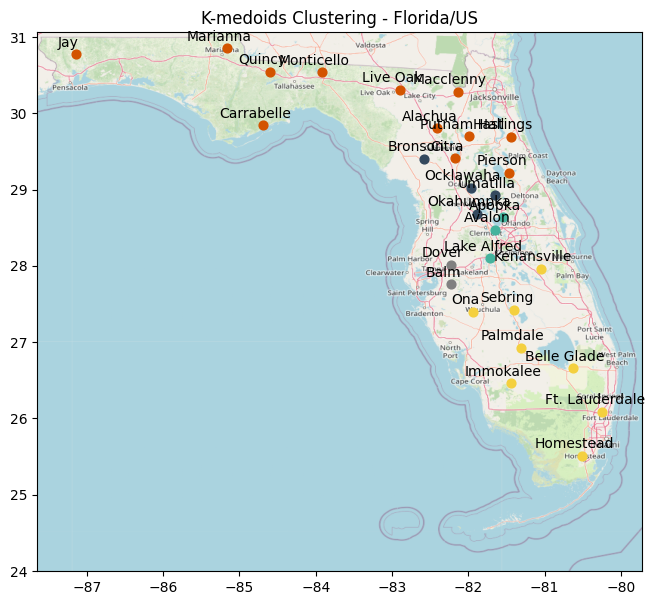

In [43]:
# K = 5
n_clusters=5
y_pred_Kmedoids_std, cluster_medoids_std = cluster_labels_TSKMedoids(df_array_std, n_clusters, 300)
stations_map = stations[stations.StationID.isin(unique_station_ids) == True]
plot_map_clustering_names(stations_map,y_pred_Kmedoids_std, "K-medoids Clustering - Florida/US","fawn")

# cluster evaluation
calculate_cluster_rmse(flattened_df_std, y_pred_Kmedoids_std)

Cluster 0
RMSE for station 0: 0.40765429229596784
RMSE for station 1: 0.2872509798263103
RMSE for station 2: 0.28837347754142084
RMSE for station 3: 0.34117489323042277
RMSE for Cluster 0: 0.33111341072353045
Cluster 1
RMSE for station 0: 0.3456195873733139
RMSE for station 1: 0.37571659197789103
RMSE for Cluster 1: 0.3606680896756025
Cluster 2
RMSE for station 0: 0.25681189102432533
RMSE for station 1: 0.3012456295287593
RMSE for station 2: 0.2569955110444531
RMSE for Cluster 2: 0.2716843438658459
Cluster 3
RMSE for station 0: 0.40527686543360864
RMSE for station 1: 0.316747623713974
RMSE for station 2: 0.34408570306409914
RMSE for station 3: 0.2595517741223529
RMSE for station 4: 0.31180694058693786
RMSE for station 5: 0.3002774667494533
RMSE for station 6: 0.3139672308232446
RMSE for station 7: 0.35957987853693407
RMSE for Cluster 3: 0.3264116853788256
Cluster 4
RMSE for station 0: 0.408822979654766
RMSE for station 1: 0.38621637261171476
RMSE for station 2: 0.40190600150604106
RMSE

0.3388178661956805

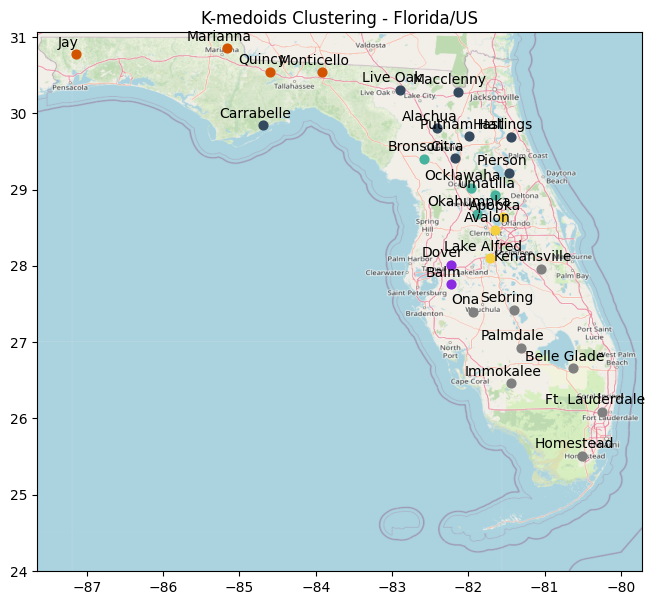

In [44]:
# K = 6
n_clusters=6
y_pred_Kmedoids_std, cluster_medoids_std = cluster_labels_TSKMedoids(df_array_std, n_clusters, 300)
stations_map = stations[stations.StationID.isin(unique_station_ids) == True]
plot_map_clustering_names(stations_map,y_pred_Kmedoids_std, "K-medoids Clustering - Florida/US","fawn")

# cluster evaluation
calculate_cluster_rmse(flattened_df_std, y_pred_Kmedoids_std)

Cluster 0
RMSE for station 0: 0.3074345970380549
RMSE for station 1: 0.288422112789152
RMSE for station 2: 0.3417244450019843
RMSE for Cluster 0: 0.31252705160973043
Cluster 1
RMSE for station 0: 0.4871204467193693
RMSE for station 1: 0.3404202554396245
RMSE for station 2: 0.25592715296026897
RMSE for station 3: 0.4445771774793811
RMSE for station 4: 0.35253418119509894
RMSE for Cluster 1: 0.37611584275874854
Cluster 2
RMSE for station 0: 0.3456195873733139
RMSE for station 1: 0.37571659197789103
RMSE for Cluster 2: 0.3606680896756025
Cluster 3
RMSE for station 0: 0.412893982844579
RMSE for station 1: 0.38712179644900574
RMSE for Cluster 3: 0.40000788964679235
Cluster 4
RMSE for station 0: 0.408822979654766
RMSE for station 1: 0.38621637261171476
RMSE for station 2: 0.40190600150604106
RMSE for station 3: 0.486002094856305
RMSE for station 4: 0.44483394700371837
RMSE for station 5: 0.393374042027681
RMSE for station 6: 0.30650991365813934
RMSE for station 7: 0.3358758151253299
RMSE for

0.3459658585778514

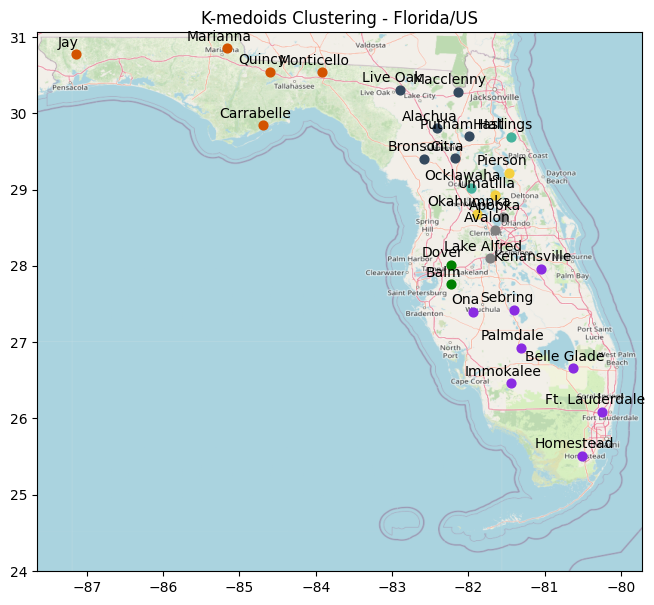

In [45]:
# K = 7
n_clusters=7
y_pred_Kmedoids_std, cluster_medoids_std = cluster_labels_TSKMedoids(df_array_std, n_clusters, 300)
stations_map = stations[stations.StationID.isin(unique_station_ids) == True]
plot_map_clustering_names(stations_map,y_pred_Kmedoids_std, "K-medoids Clustering - Florida/US","fawn")

# cluster evaluation
calculate_cluster_rmse(flattened_df_std, y_pred_Kmedoids_std)

In [46]:
# HIERARCHICAL CLUSTERING

list_names_dendogram = []
for index, row in names_sort.iterrows():
    stID = row['StationID']
    if stID in unique_station_ids:
        list_names_dendogram.append(row['StationName'])
        
list_names_dendogram

['Jay',
 'Marianna',
 'Quincy',
 'Carrabelle',
 'Monticello',
 'Live Oak',
 'Macclenny',
 'Bronson',
 'Putnam Hall',
 'Citra',
 'Alachua',
 'Hastings',
 'Ocklawaha',
 'Pierson',
 'Umatilla',
 'Okahumpka',
 'Avalon',
 'Apopka',
 'Lake Alfred',
 'Kenansville',
 'Balm',
 'Dover',
 'Ona',
 'Belle Glade',
 'Ft. Lauderdale',
 'Homestead',
 'Immokalee',
 'Palmdale',
 'Sebring']

In [47]:
sil_score_TSHierarcClustering(df_array_std)

Clusters = 2  Silhouette Score: 0.221
Clusters = 3  Silhouette Score: 0.182
Clusters = 4  Silhouette Score: 0.195
Clusters = 5  Silhouette Score: 0.195
Clusters = 6  Silhouette Score: 0.175
Clusters = 7  Silhouette Score: 0.170
Clusters = 8  Silhouette Score: 0.158
Clusters = 9  Silhouette Score: 0.137
Clusters = 10  Silhouette Score: 0.131
Clusters = 11  Silhouette Score: 0.114
Clusters = 12  Silhouette Score: 0.115
Clusters = 13  Silhouette Score: 0.105
Clusters = 14  Silhouette Score: 0.101
Clusters = 15  Silhouette Score: 0.095
Clusters = 16  Silhouette Score: 0.087
Clusters = 17  Silhouette Score: 0.082
Clusters = 18  Silhouette Score: 0.078
Clusters = 19  Silhouette Score: 0.068
Clusters = 20  Silhouette Score: 0.059
Clusters = 21  Silhouette Score: 0.054
Clusters = 22  Silhouette Score: 0.045
Clusters = 23  Silhouette Score: 0.038
Clusters = 24  Silhouette Score: 0.031
Clusters = 25  Silhouette Score: 0.023
Clusters = 26  Silhouette Score: 0.018
Clusters = 27  Silhouette Score: 

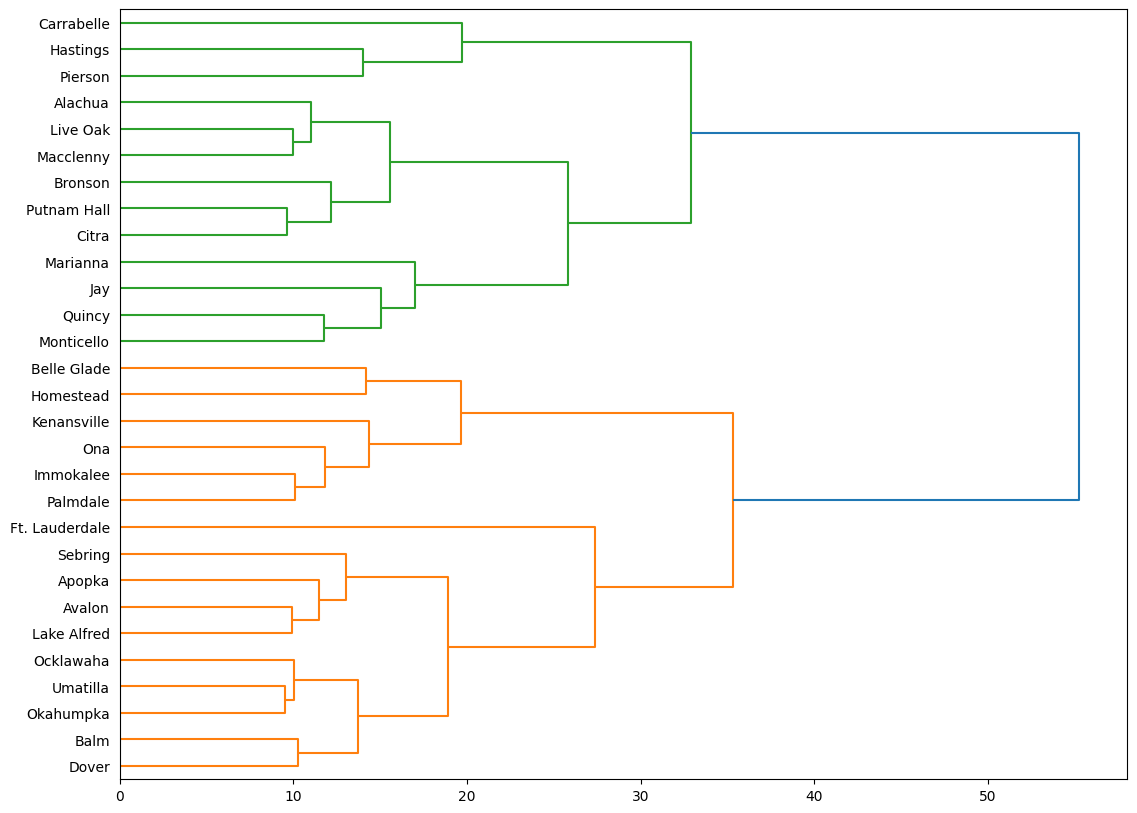

Cluster 1
RMSE for station 0: 0.4830394145191497
RMSE for station 1: 0.35259612470497137
RMSE for station 2: 0.28448058375945806
RMSE for station 3: 0.4093002852070805
RMSE for station 4: 0.355309146243103
RMSE for station 5: 0.3161886746296748
RMSE for station 6: 0.33985876774390233
RMSE for station 7: 0.32194211457287
RMSE for station 8: 0.2740314658247366
RMSE for station 9: 0.3248629111860842
RMSE for station 10: 0.31032425299109934
RMSE for station 11: 0.33586230501322345
RMSE for station 12: 0.3933630976043854
RMSE for Cluster 1: 0.346243011076903
Cluster 2
RMSE for station 0: 0.3284571933637548
RMSE for station 1: 0.3466887121757076
RMSE for station 2: 0.3582278119449044
RMSE for station 3: 0.3102558835674096
RMSE for station 4: 0.36055814141598924
RMSE for station 5: 0.24936131157803423
RMSE for station 6: 0.41456387049284593
RMSE for station 7: 0.3807714154261542
RMSE for station 8: 0.38667013677523326
RMSE for station 9: 0.41655166921791614
RMSE for station 10: 0.472938184805

0.3650677865829775

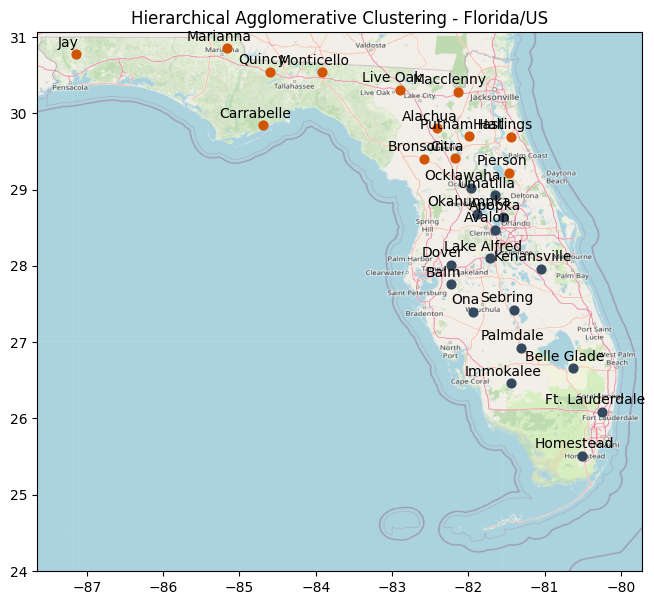

In [48]:
# K = 2
n_clusters=2
h_cluster_labels_std, h_linkage_matrix_std = dendogram_TSHierarcClustering(df_array_std, n_clusters, list_names_dendogram)
list_index_dendogram_std = leaves_list(h_linkage_matrix_std)
stations_map = stations[stations.StationID.isin(unique_station_ids) == True]
plot_map_clustering_names(stations_map,h_cluster_labels_std, "Hierarchical Agglomerative Clustering - Florida/US","fawn")

# cluster evaluation
calculate_cluster_rmse(flattened_df_std, h_cluster_labels_std)

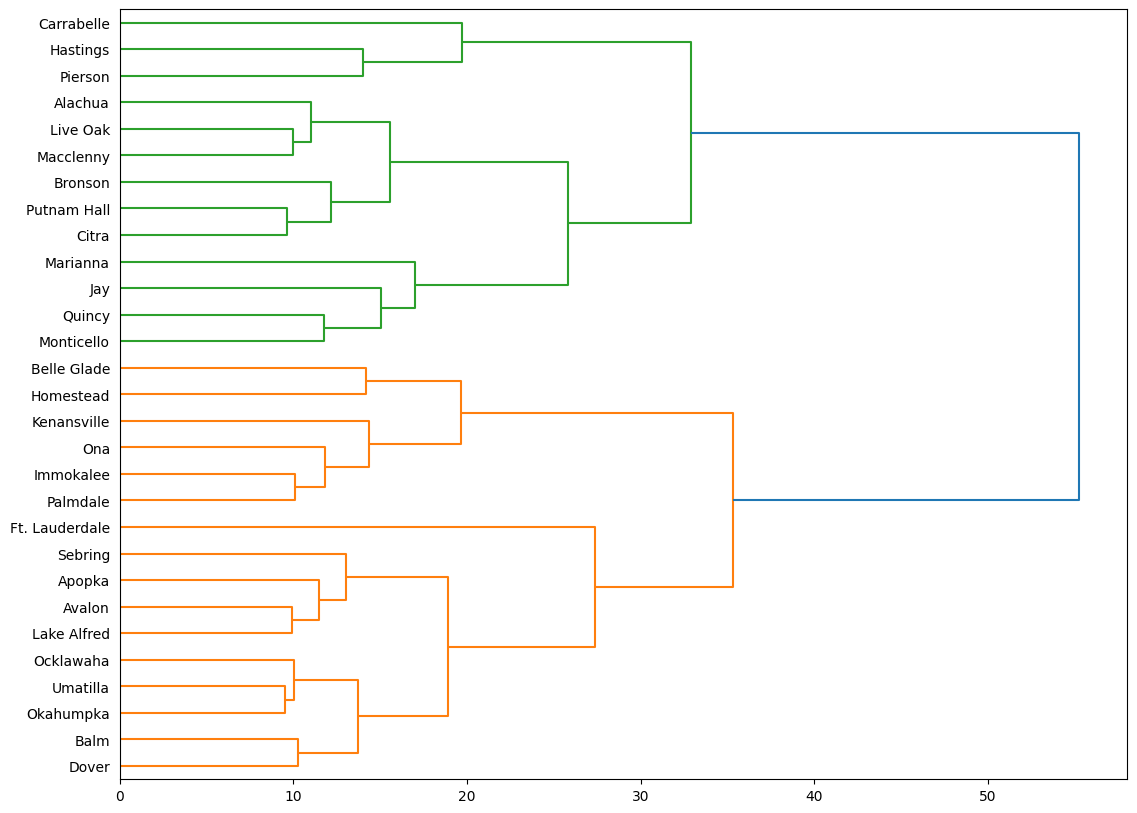

Cluster 1
RMSE for station 0: 0.4830394145191497
RMSE for station 1: 0.35259612470497137
RMSE for station 2: 0.28448058375945806
RMSE for station 3: 0.4093002852070805
RMSE for station 4: 0.355309146243103
RMSE for station 5: 0.3161886746296748
RMSE for station 6: 0.33985876774390233
RMSE for station 7: 0.32194211457287
RMSE for station 8: 0.2740314658247366
RMSE for station 9: 0.3248629111860842
RMSE for station 10: 0.31032425299109934
RMSE for station 11: 0.33586230501322345
RMSE for station 12: 0.3933630976043854
RMSE for Cluster 1: 0.346243011076903
Cluster 2
RMSE for station 0: 0.44828547937779206
RMSE for station 1: 0.39944542097977115
RMSE for station 2: 0.3959944458884616
RMSE for station 3: 0.4657116508154838
RMSE for station 4: 0.3912361532745505
RMSE for station 5: 0.3190748472986228
RMSE for Cluster 2: 0.4032913329391137
Cluster 3
RMSE for station 0: 0.3243201557130218
RMSE for station 1: 0.29316101375298625
RMSE for station 2: 0.34600864174136703
RMSE for station 3: 0.2863

0.36301618053074686

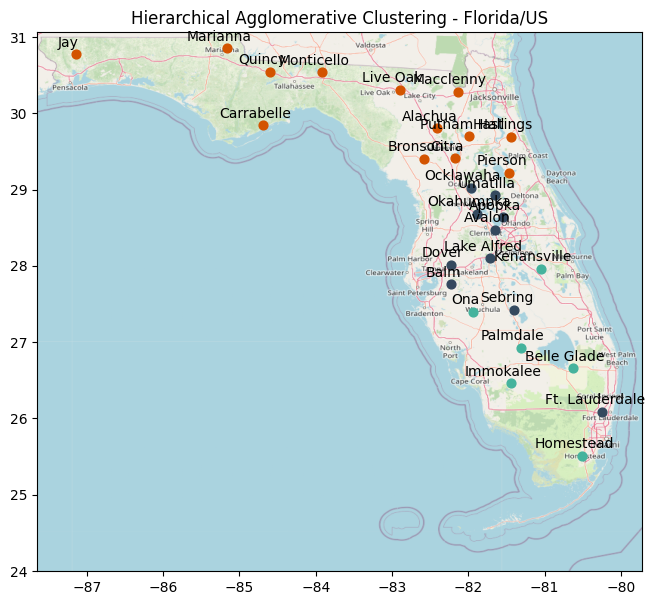

In [49]:
# K = 3
n_clusters=3
h_cluster_labels_std, h_linkage_matrix_std = dendogram_TSHierarcClustering(df_array_std, n_clusters, list_names_dendogram)
list_index_dendogram_std = leaves_list(h_linkage_matrix_std)
stations_map = stations[stations.StationID.isin(unique_station_ids) == True]
plot_map_clustering_names(stations_map,h_cluster_labels_std, "Hierarchical Agglomerative Clustering - Florida/US","fawn")

# cluster evaluation
calculate_cluster_rmse(flattened_df_std, h_cluster_labels_std)

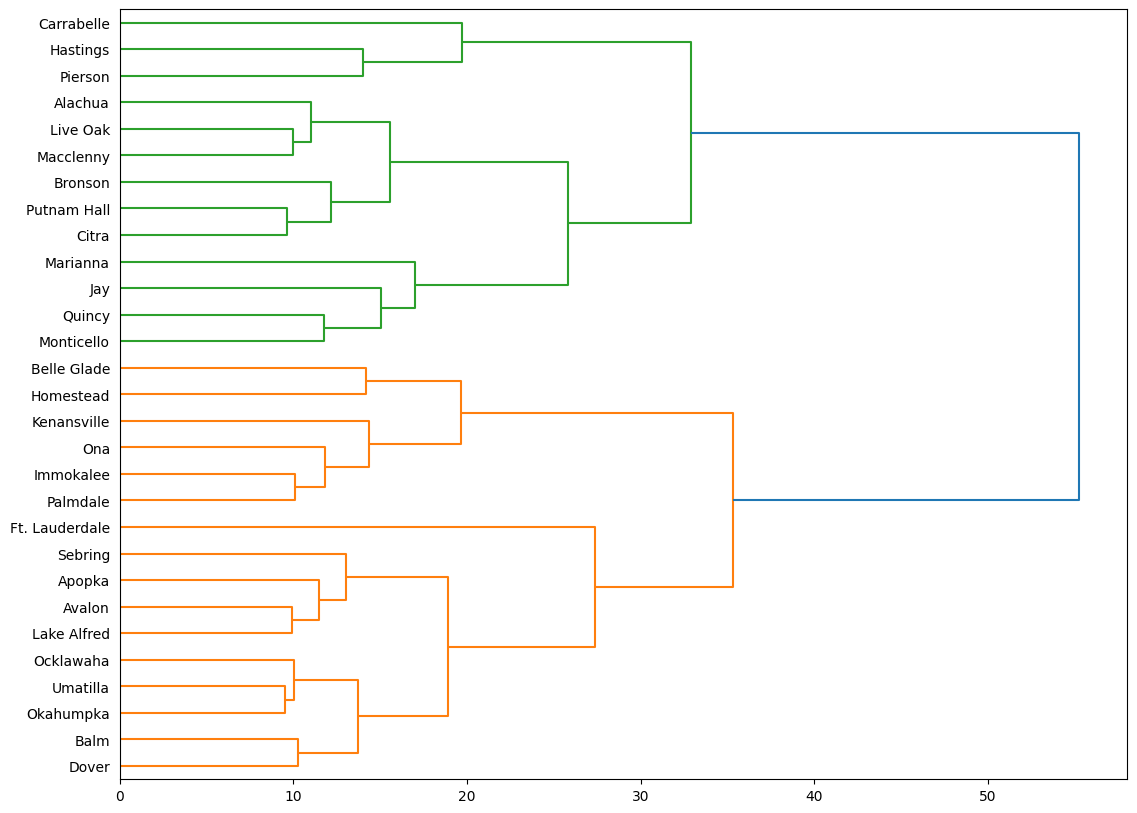

Cluster 1
RMSE for station 0: 0.539148202249284
RMSE for station 1: 0.3624328407062014
RMSE for station 2: 0.34633470576505465
RMSE for Cluster 1: 0.41597191624018004
Cluster 2
RMSE for station 0: 0.45418681448390436
RMSE for station 1: 0.3303458786704735
RMSE for station 2: 0.27542655820001977
RMSE for station 3: 0.3514960585792287
RMSE for station 4: 0.3285241532007428
RMSE for station 5: 0.35216611969285083
RMSE for station 6: 0.30887938887474087
RMSE for station 7: 0.2578971950176722
RMSE for station 8: 0.2920969883602033
RMSE for station 9: 0.28546042361748686
RMSE for Cluster 2: 0.32364795786973233
Cluster 3
RMSE for station 0: 0.44828547937779206
RMSE for station 1: 0.39944542097977115
RMSE for station 2: 0.3959944458884616
RMSE for station 3: 0.4657116508154838
RMSE for station 4: 0.3912361532745505
RMSE for station 5: 0.3190748472986228
RMSE for Cluster 3: 0.4032913329391137
Cluster 4
RMSE for station 0: 0.3243201557130218
RMSE for station 1: 0.29316101375298625
RMSE for stati

0.3706063511563125

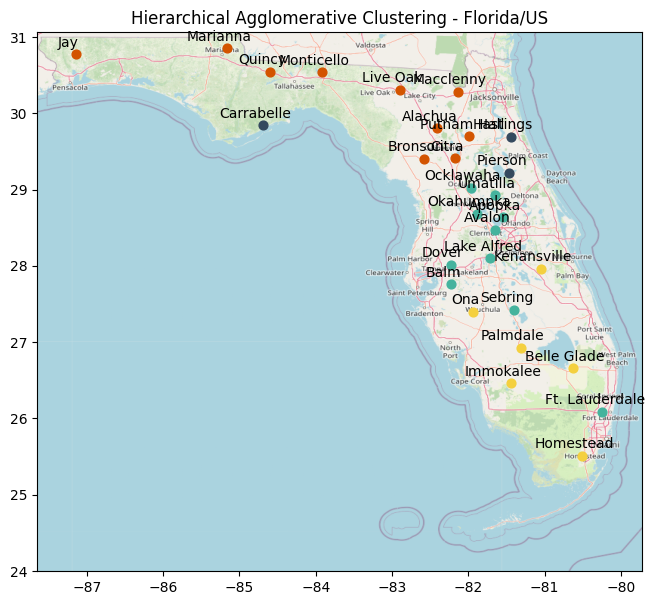

In [50]:
# K = 4
n_clusters=4
h_cluster_labels_std, h_linkage_matrix_std = dendogram_TSHierarcClustering(df_array_std, n_clusters, list_names_dendogram)
list_index_dendogram_std = leaves_list(h_linkage_matrix_std)
stations_map = stations[stations.StationID.isin(unique_station_ids) == True]
plot_map_clustering_names(stations_map,h_cluster_labels_std, "Hierarchical Agglomerative Clustering - Florida/US","fawn")

# cluster evaluation
calculate_cluster_rmse(flattened_df_std, h_cluster_labels_std)

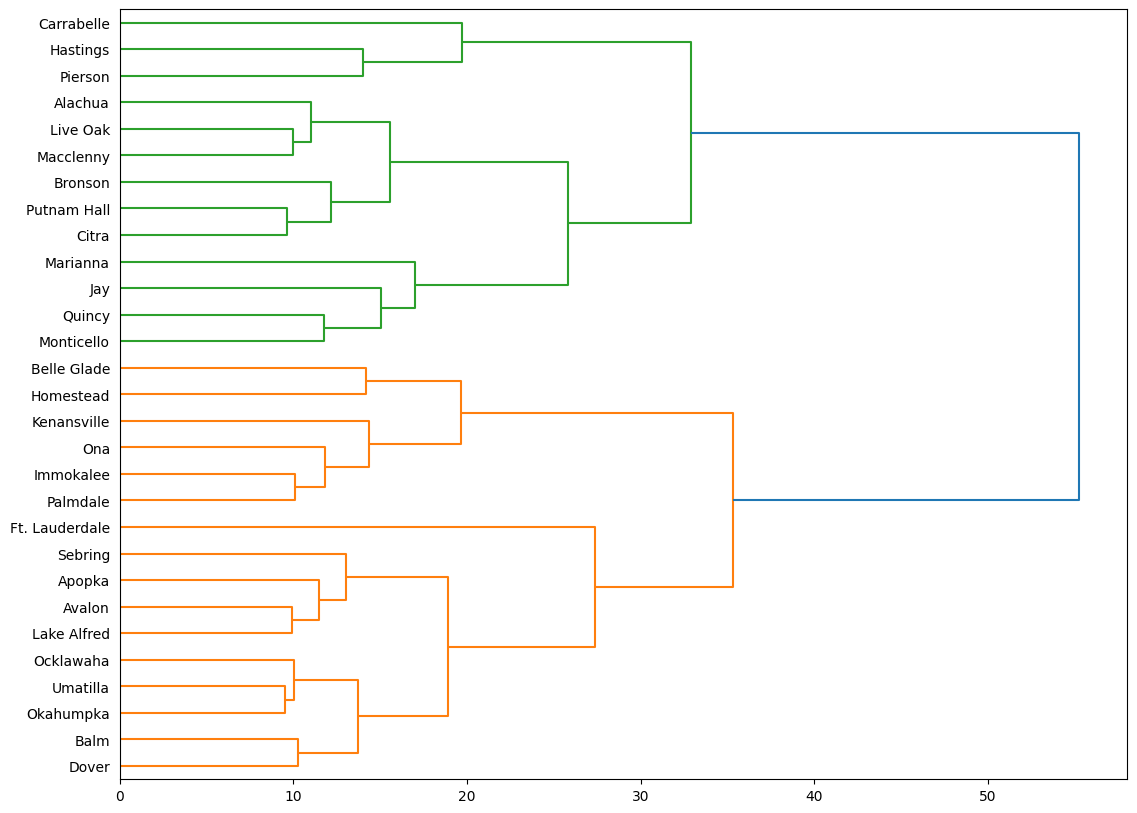

Cluster 1
RMSE for station 0: 0.539148202249284
RMSE for station 1: 0.3624328407062014
RMSE for station 2: 0.34633470576505465
RMSE for Cluster 1: 0.41597191624018004
Cluster 2
RMSE for station 0: 0.45418681448390436
RMSE for station 1: 0.3303458786704735
RMSE for station 2: 0.27542655820001977
RMSE for station 3: 0.3514960585792287
RMSE for station 4: 0.3285241532007428
RMSE for station 5: 0.35216611969285083
RMSE for station 6: 0.30887938887474087
RMSE for station 7: 0.2578971950176722
RMSE for station 8: 0.2920969883602033
RMSE for station 9: 0.28546042361748686
RMSE for Cluster 2: 0.32364795786973233
Cluster 3
RMSE for station 0: 0.44828547937779206
RMSE for station 1: 0.39944542097977115
RMSE for station 2: 0.3959944458884616
RMSE for station 3: 0.4657116508154838
RMSE for station 4: 0.3912361532745505
RMSE for station 5: 0.3190748472986228
RMSE for Cluster 3: 0.4032913329391137
Cluster 4
RMSE for station 0: 0.3095534914798923
RMSE for station 1: 0.2908160402921319
RMSE for statio

0.2928646622231845

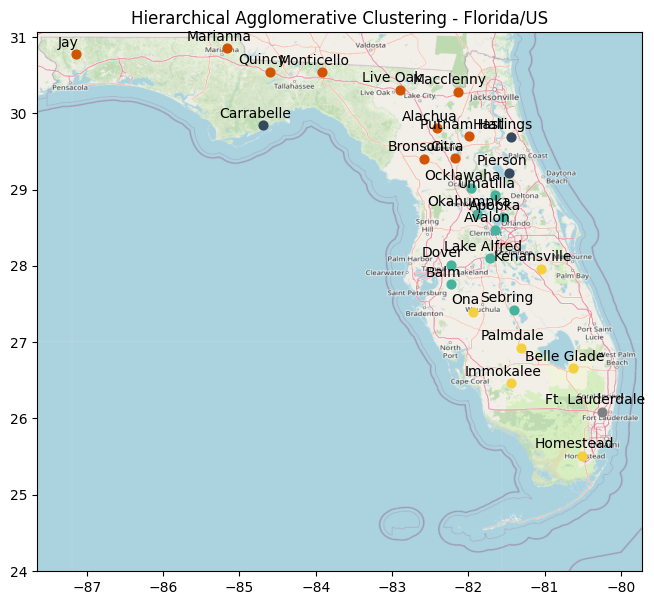

In [51]:
# K = 5
n_clusters=5
h_cluster_labels_std, h_linkage_matrix_std = dendogram_TSHierarcClustering(df_array_std, n_clusters, list_names_dendogram)
list_index_dendogram_std = leaves_list(h_linkage_matrix_std)
stations_map = stations[stations.StationID.isin(unique_station_ids) == True]
plot_map_clustering_names(stations_map,h_cluster_labels_std, "Hierarchical Agglomerative Clustering - Florida/US","fawn")

# cluster evaluation
calculate_cluster_rmse(flattened_df_std, h_cluster_labels_std)

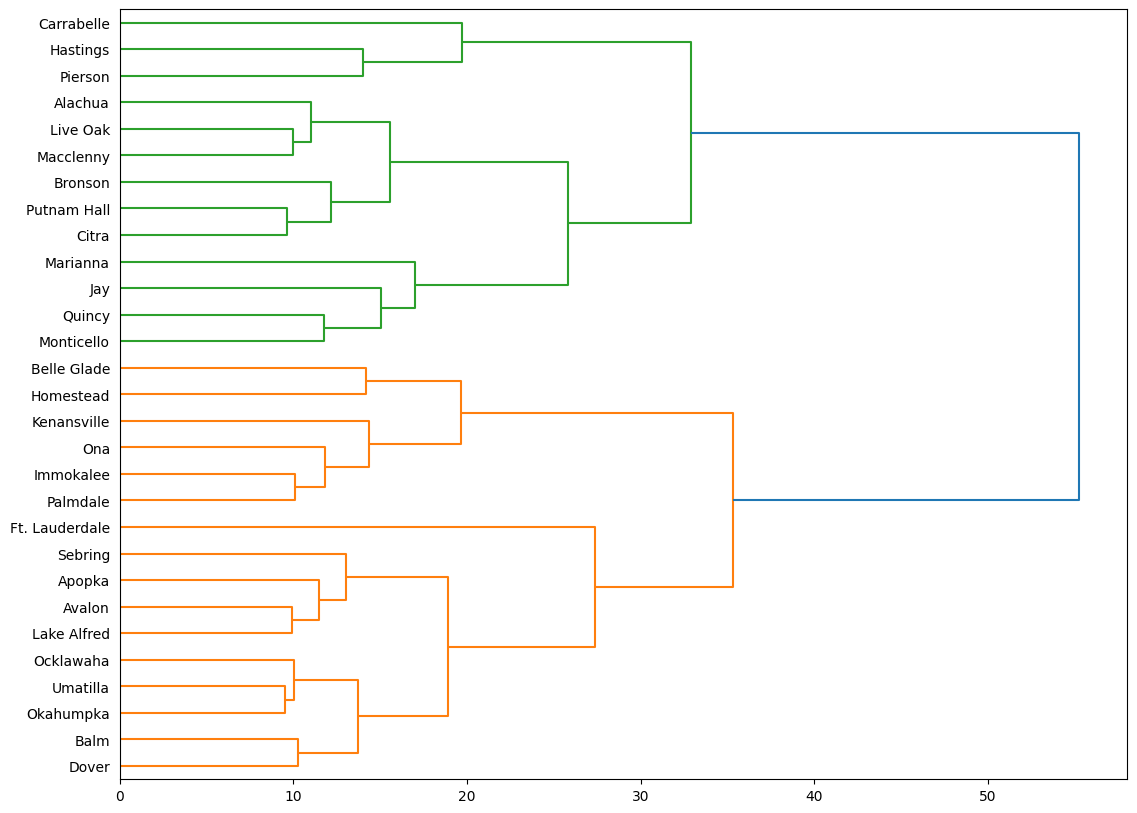

Cluster 1
RMSE for station 0: 0.539148202249284
RMSE for station 1: 0.3624328407062014
RMSE for station 2: 0.34633470576505465
RMSE for Cluster 1: 0.41597191624018004
Cluster 2
RMSE for station 0: 0.3337553275223485
RMSE for station 1: 0.35786984921050513
RMSE for station 2: 0.30300171805901216
RMSE for station 3: 0.26843300897894784
RMSE for station 4: 0.28557619179009786
RMSE for station 5: 0.2832547845357559
RMSE for Cluster 2: 0.30531514668277787
Cluster 3
RMSE for station 0: 0.4646491171527515
RMSE for station 1: 0.33034505293206684
RMSE for station 2: 0.2568516199155326
RMSE for station 3: 0.33850229689891403
RMSE for Cluster 3: 0.34758702172481626
Cluster 4
RMSE for station 0: 0.44828547937779206
RMSE for station 1: 0.39944542097977115
RMSE for station 2: 0.3959944458884616
RMSE for station 3: 0.4657116508154838
RMSE for station 4: 0.3912361532745505
RMSE for station 5: 0.3190748472986228
RMSE for Cluster 4: 0.4032913329391137
Cluster 5
RMSE for station 0: 0.3095534914798923
RMS

0.2989295869422974

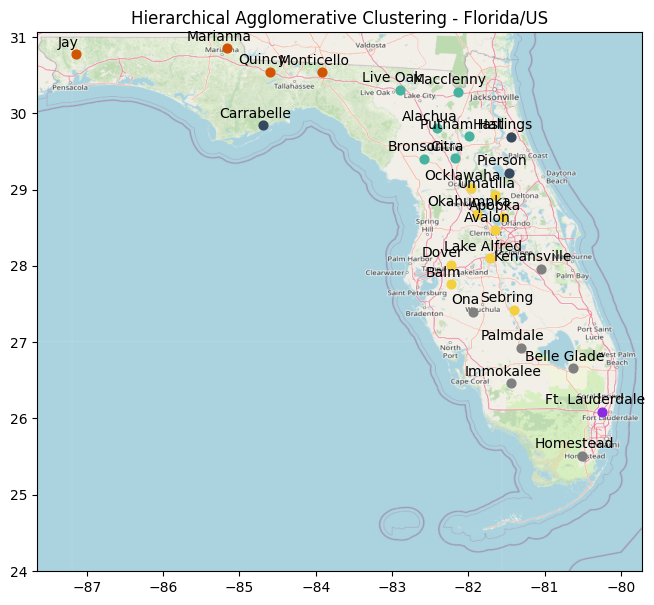

In [52]:
# K = 6
n_clusters=6
h_cluster_labels_std, h_linkage_matrix_std = dendogram_TSHierarcClustering(df_array_std, n_clusters, list_names_dendogram)
list_index_dendogram_std = leaves_list(h_linkage_matrix_std)
stations_map = stations[stations.StationID.isin(unique_station_ids) == True]
plot_map_clustering_names(stations_map,h_cluster_labels_std, "Hierarchical Agglomerative Clustering - Florida/US","fawn")

# cluster evaluation
calculate_cluster_rmse(flattened_df_std, h_cluster_labels_std)

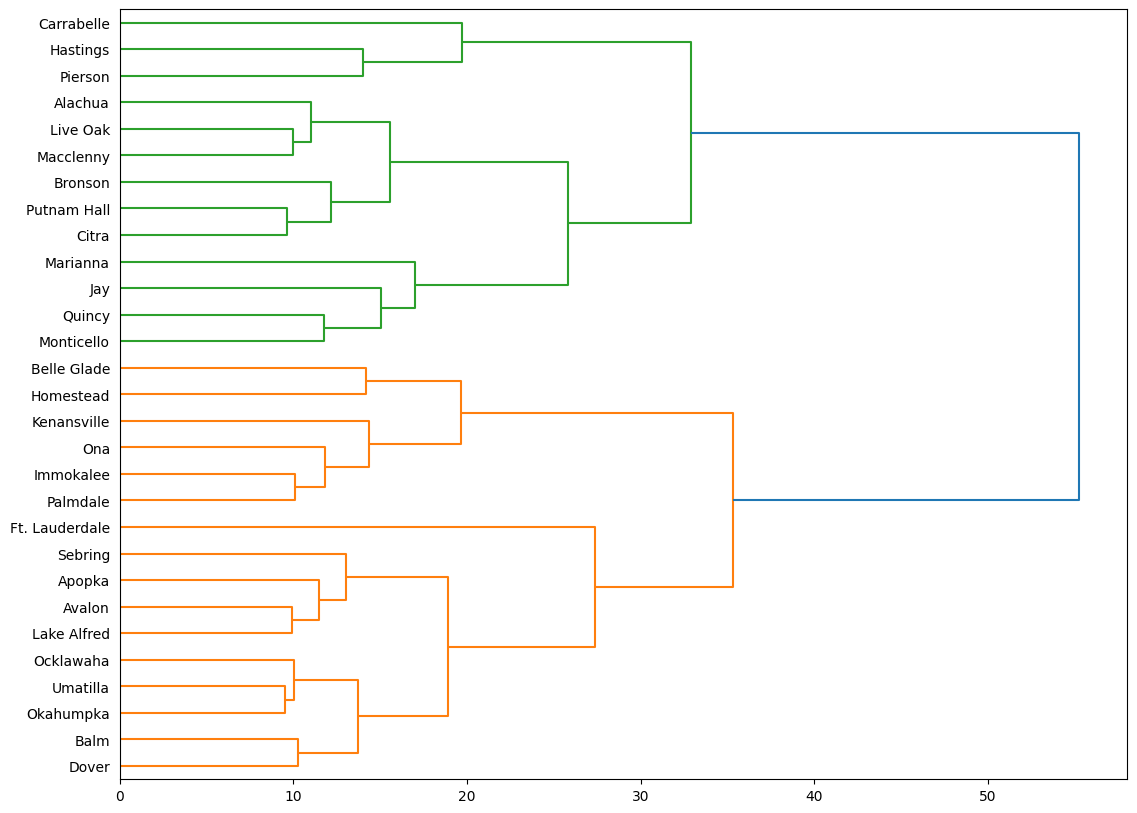

Cluster 1
RMSE for station 0: 0.3691274497761077
RMSE for station 1: 0.3519141494870151
RMSE for Cluster 1: 0.36052079963156136
Cluster 2
RMSE for Cluster 2: 0.0
Cluster 3
RMSE for station 0: 0.3337553275223485
RMSE for station 1: 0.35786984921050513
RMSE for station 2: 0.30300171805901216
RMSE for station 3: 0.26843300897894784
RMSE for station 4: 0.28557619179009786
RMSE for station 5: 0.2832547845357559
RMSE for Cluster 3: 0.30531514668277787
Cluster 4
RMSE for station 0: 0.4646491171527515
RMSE for station 1: 0.33034505293206684
RMSE for station 2: 0.2568516199155326
RMSE for station 3: 0.33850229689891403
RMSE for Cluster 4: 0.34758702172481626
Cluster 5
RMSE for station 0: 0.44828547937779206
RMSE for station 1: 0.39944542097977115
RMSE for station 2: 0.3959944458884616
RMSE for station 3: 0.4657116508154838
RMSE for station 4: 0.3912361532745505
RMSE for station 5: 0.3190748472986228
RMSE for Cluster 5: 0.4032913329391137
Cluster 6
RMSE for station 0: 0.3095534914798923
RMSE for

0.24830377214930938

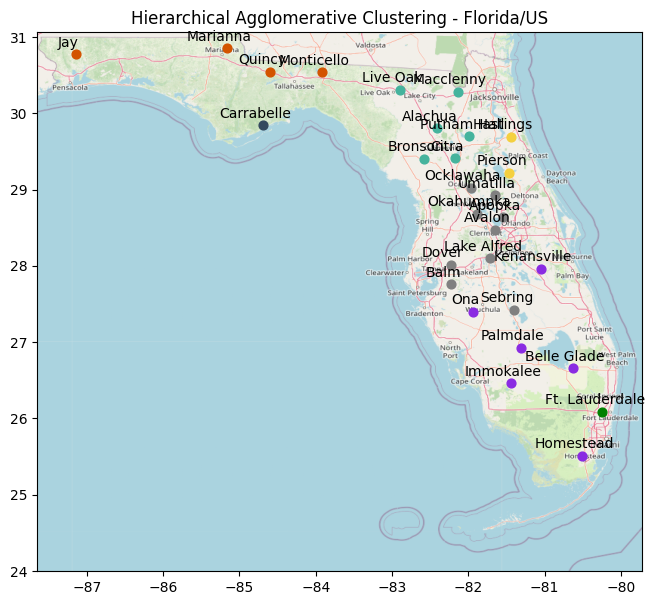

In [53]:
# K = 7
n_clusters=7
h_cluster_labels_std, h_linkage_matrix_std = dendogram_TSHierarcClustering(df_array_std, n_clusters, list_names_dendogram)
list_index_dendogram_std = leaves_list(h_linkage_matrix_std)
stations_map = stations[stations.StationID.isin(unique_station_ids) == True]
plot_map_clustering_names(stations_map,h_cluster_labels_std, "Hierarchical Agglomerative Clustering - Florida/US","fawn")

# cluster evaluation
calculate_cluster_rmse(flattened_df_std, h_cluster_labels_std)